In [1]:
import pyscf
import pyscf.tools
import pyscf.cc
import pyscf.qmmm
from pyscf import lib
from pyscf import gto
from pyscf import df
from pyscf import scf
from pyscf import mcscf
from pyscf import grad
from pyscf.lib import logger
from pyscf.scf import RHF
import pyscf.lib
import numpy as np
import numpy
import matplotlib.pyplot as plt
angstrom=1.889725989

In [2]:
NN=pyscf.gto.M(atom='N 0 0 1.1; N 0 0 0', basis='sto3G', verbose=3)
mf=RHF(NN)
mf.scf()

converged SCF energy = -107.496500511798


-107.4965005117978

In [3]:
# the operators in 2nd quantiation
print(mf.get_hcore()[0])  #monoelettronic NE + kin   
print(mf.get_veff()[0])  # bielettronic operator takes as input argument (mol, dm )
print(mf.make_rdm1()[0])  # density matrix

[-2.75627018e+01 -6.35285045e+00  0.00000000e+00  0.00000000e+00
  9.38535097e-02 -3.00178430e-04 -1.39169276e+00  0.00000000e+00
  0.00000000e+00 -2.31837148e+00]
[ 1.20533259e+01  2.41964519e+00  4.91562321e-18 -6.42030596e-17
 -6.11342362e-02 -4.79474449e-04  5.24307596e-01 -2.28026399e-19
 -1.22029623e-17  8.81504407e-01]
[ 2.10647611e+00 -4.26665347e-01 -1.92629107e-17  1.27355136e-16
 -1.06156169e-01  1.33150500e-02  6.20895753e-03  1.15869317e-17
  5.33785411e-17 -1.01810643e-01]


In [4]:
#get the partial energy
print(mf.energy_elec())
print(mf.energy_nuc(),'equally',NN.energy_nuc())
print(mf.energy_tot())
print(mf.energy_elec()[0]+mf.energy_nuc())

(-131.06893990732507, 61.31408085684189)
23.572439395527272 equally 23.572439395527272
-107.4965005117978
-107.4965005117978


In [5]:
dm=mf.make_rdm1()
h1=mf.get_hcore()
h2=mf.get_veff()
S=mf.get_ovlp()

In [6]:
# examples of contraction
print ('monoelettronic enegy = ',np.einsum('ij,ji',h1,dm))
print ('Bielettronic enegy = ',np.einsum('ij,ji',h2,dm)/2)
print ('the sum of those two equals = ',mf.energy_elec()[0])
print('Total number of electrons= ',np.einsum('ij,ji',S,dm))

monoelettronic enegy =  -192.38302076416696
Bielettronic enegy =  61.31408085684189
the sum of those two equals =  -131.06893990732507
Total number of electrons=  14.000000000000002


In [7]:
"""
| mf.get_init_guess
            | mf.get_hcore
            | mf.get_ovlp
            | mf.get_veff
            | mf.get_fock
            | mf.get_grad
            | mf.eig
            | mf.get_occ
            | mf.make_rdm1
            | mf.energy_tot
            | mf.dump_chk
"""


'\n| mf.get_init_guess\n            | mf.get_hcore\n            | mf.get_ovlp\n            | mf.get_veff\n            | mf.get_fock\n            | mf.get_grad\n            | mf.eig\n            | mf.get_occ\n            | mf.make_rdm1\n            | mf.energy_tot\n            | mf.dump_chk\n'

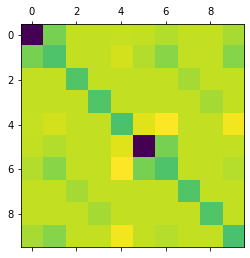

In [8]:
plt.matshow(NN.intor_symmetric('int1e_nuc'))

In [9]:
print(NN._atm)
mf.scf()

[[ 7 20  1 23  0  0]
 [ 7 24  1 27  0  0]]
converged SCF energy = -107.496500511798


-107.49650051179783

In [23]:
print(NN.nao)
print(NN._bas)
print(NN._env)
from pyscf import lib

10
[[ 0  0  3  1  0 28 31  0]
 [ 0  0  3  1  0 34 37  0]
 [ 0  1  3  1  0 40 43  0]
 [ 1  0  3  1  0 28 31  0]
 [ 1  0  3  1  0 34 37  0]
 [ 1  1  3  1  0 40 43  0]]
[137.03599968   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           2.07869874   0.           0.
   0.           0.           0.          99.106169    18.052312
   4.8856602   12.24723354  11.84499063   3.69156624   3.7804559
   0.8784966    0.2857144   -0.68474806   0.91590581   0.69124784
   3.7804559    0.8784966    0.2857144    2.39776185   1.50777694
   0.23885724]


In [48]:
#copy and paste of the qmm_charge method to obtain the delta V operator on the AO basis 

print(NN.unit)
print(NN.cart)
intor = 'int3c2e_sph'
cintopt = gto.moleintor.make_cintopt(NN._atm, NN._bas,NN._env, intor)
coords,charges=NN.atom_coords(), np.asarray([-1,1])
dv = 0
blksize = int(min(mf.max_memory*1e6/8/NN.nao**2, 200))
print(blksize)
for i0, i1 in lib.prange(0, charges.size, blksize):
    fakemol = gto.fakemol_for_charges(coords[i0:i1])
    j3c = df.incore.aux_e2(NN, fakemol, intor=intor, aosym='s2ij', cintopt=cintopt)
    dv += numpy.einsum('xk,k->x', j3c, -charges[i0:i1])

angstrom
False
200


In [49]:
dv = lib.unpack_tril(dv)
dv.shape

(10, 10)

In [51]:
np.einsum('ij,ji',dv,dm) # the first alchemical derivative is null

4.773959005888173e-15

In [55]:
CO=pyscf.gto.M(atom='C 0 0 0;O 0 0 1.1',basis='sto3G')
mfc=RHF(CO)
mfc.kernel()

converged SCF energy = -111.219048454705


-111.21904845470533

In [56]:
dmc=mfc.make_rdm1()


In [64]:
def first_a_der(mol,charges=np.asarray([1,-1])):
    intor = 'int3c2e_sph'
    cintopt = gto.moleintor.make_cintopt(mol._atm, mol._bas, mol._env, intor)
    coords=mol.atom_coords()
    dV = 0
    blksize = int(min(mf.max_memory*1e6/8/mol.nao**2, 200))
    for i0, i1 in lib.prange(0, charges.size, blksize):
        fakemol = gto.fakemol_for_charges(coords[i0:i1])
        j3c = df.incore.aux_e2(mol, fakemol, intor=intor, aosym='s2ij', cintopt=cintopt)
        dV += numpy.einsum('xk,k->x', j3c, -charges[i0:i1])
    dV = lib.unpack_tril(dV)
    return dV


In [71]:
dV_CO=first_a_der(CO)

In [72]:
np.einsum('ij,ji',first_a_der(CO),dmc)

6.340187073203955

In [78]:
def dens_dh(mol,dh):
    deltaZ = np.array((dh,-dh))
    mf = pyscf.qmmm.mm_charge(pyscf.scf.RHF(mol), mol.atom_coords()/1.889725989, deltaZ)
    class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
            e_nuc=self.mol.energy_nuc()
            e_nuc-=dh**2/np.linalg.norm(self.mol.atom_coords()[0]-self.mol.atom_coords()[1])
            return e_nuc
    mf = NoSelfQMMM()
    en=mf.scf()
    return mf.make_rdm1(),en

In [79]:
dens_dh(CO,.1)

converged SCF energy = -110.599886208879


(array([[ 2.12035010e+00, -4.46878090e-01,  1.05291460e-16,
          3.74413100e-17,  1.27357892e-01,  1.40044952e-02,
         -2.18328418e-03, -2.17107845e-17,  2.95031684e-17,
          1.20998756e-01],
        [-4.46878090e-01,  1.85094505e+00, -4.97338852e-16,
         -4.40696163e-16, -7.19634444e-01,  9.36277832e-03,
         -2.62520639e-01,  8.44289834e-17, -1.96724483e-16,
         -1.27658657e-01],
        [ 1.05291460e-16, -4.97338852e-16,  4.56364231e-01,
         -4.30211422e-16,  2.56498428e-16,  1.27449897e-17,
         -1.27167633e-17,  7.27497376e-01, -3.05311332e-16,
         -2.70857052e-16],
        [ 3.74413100e-17, -4.40696163e-16, -4.30211422e-16,
          4.56364231e-01,  1.68591706e-16, -7.41331220e-16,
          3.62333502e-16, -1.94289029e-16,  7.27497376e-01,
         -6.25678114e-16],
        [ 1.27357892e-01, -7.19634444e-01,  2.56498428e-16,
          1.68591706e-16,  7.49259873e-01, -8.78793599e-02,
          1.39558796e-01, -2.20523998e-16, -5.780904

In [80]:
dens_dh(CO,1)

converged SCF energy = -106.405205737936


(array([[ 2.13232892e+00, -5.11530998e-01, -4.15007279e-17,
          1.32632097e-17,  4.00106657e-02,  1.71451985e-02,
          5.48760494e-02, -3.99961334e-17,  2.79525018e-17,
          7.05546465e-02],
        [-5.11530998e-01,  1.92595341e+00, -2.58475379e-17,
         -8.10504003e-17, -5.27837524e-01, -1.18439125e-01,
         -1.58678198e-01,  7.24869278e-17, -2.06156383e-16,
         -1.95794297e-01],
        [-4.15007279e-17, -2.58475379e-17,  1.08779929e+00,
         -1.22124533e-15, -1.41706301e-18, -3.77113561e-17,
          1.86368615e-16,  7.49635729e-01,  6.66133815e-16,
         -4.77664125e-16],
        [ 1.32632097e-17, -8.10504003e-17, -1.22124533e-15,
          1.08779929e+00, -4.73536021e-16, -9.20929217e-17,
          8.60090428e-16, -5.55111512e-17,  7.49635729e-01,
          4.59245133e-16],
        [ 4.00106657e-02, -5.27837524e-01, -1.41706301e-18,
         -4.73536021e-16,  1.10072203e+00, -2.23937470e-01,
          1.43867021e-01, -1.62211991e-16,  7.240378